In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science','notebook'])

# Dinâmica Molecular no Ensemble NVE 

- $N$: número de partículas
- $V$: volume 
- $E$: energia


## Lista de Vizinhos

Nem todas as partículas estão no raio de alcance das outras. 

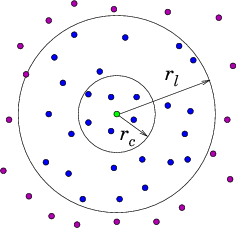

Para partículas mais distantes que $r_l$, somente após $n$ passos poderemos ter uma possível interação. 

A ideia é construir uma lista que leve em conta somente os vizinhos que estão no interior de uma esfera de raio $r_l$. 

## Cálculo da Pressão

Vimos que a energia potencial do sistema é dada por 

$$U = \frac{1}{2}\sum_{i=1}^N \sum_{j \neq i}^N u(\boldsymbol{r}_{ij})$$

Da termodinâmica, sabemos que 

$$P = \rho k_B T - \left(\frac{\partial U}{\partial V}\right)_{N,S}$$

Como a distância entre duas partículas $\boldsymbol{r}_{ij}$ pode ser escrita em termos de um comprimento característico da caixa de simulação $\ell$ tal que $\boldsymbol{r}_{ij} = \boldsymbol{s}_{ij} \ell$ e que $V = \ell^3$, podemos escrever que 

$$\left(\frac{\partial U}{\partial V}\right)_{N,S} = \frac{1}{2}\sum_{i=1}^N \sum_{j \neq i}^N \frac{\partial u(\boldsymbol{r}_{ij})}{\partial \boldsymbol{r}_{ij}} \cdot \frac{\partial \boldsymbol{r}_{ij}}{\partial V}$$

e usando que $\frac{\partial \boldsymbol{r}_{ij}}{\partial V} = \boldsymbol{r}_{ij}/(3V)$ chegamos a 

$$P = \rho k_B T + \frac{W}{3V}$$

$$W=  \frac{1}{2}\sum_{i=1}^N \sum_{j \neq i}^N \boldsymbol{f}_{ij} \cdot \boldsymbol{r}_{ij}$$

sendo $W$ o termo de virial que pode ser calculado pelo produto entre as forças e os deslocamentos. 


Função que calcula o potencial de LJ entre pares

In [2]:
def ulj(r,epsilon=1.0,sigma=1.0):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

Função que calcula a derivada do potencial de LJ entre pares

In [3]:
def duljdr(r,epsilon=1.0,sigma=1.0):
    return -48*epsilon*((sigma/r)**12-0.5*(sigma/r)**6)/r

In [4]:
class LJsystem():
    # Função que cria a classe
    def __init__(self,N_atoms, m = 1.0, epsilon = 1.0, sigma = 1.0, rcut = 2.5):
        self.N_atoms = N_atoms

        # parametros dos atomos
        self.m = m*np.ones(self.N_atoms)
        self.sigma = sigma*np.ones(self.N_atoms)
        self.epsilon = epsilon*np.ones(self.N_atoms)

        # parametro de cutoff da interação de LJ
        self.rcut = rcut

        # Arrays de posições
        self.x = np.zeros(self.N_atoms)
        self.y = np.zeros(self.N_atoms)
        self.z = np.zeros(self.N_atoms)

        # Arrays de velocidade
        self.vx = np.zeros(self.N_atoms)        
        self.vy = np.zeros(self.N_atoms) 
        self.vz = np.zeros(self.N_atoms) 

        # Arrays de aceleração
        self.ax = np.zeros(self.N_atoms)        
        self.ay = np.zeros(self.N_atoms)
        self.az = np.zeros(self.N_atoms)

    def Set_Density(self,rho):
        self.rho = rho
        # calcular o tamanho da caixa necessária 
        self.Vol = self.N_atoms/self.rho
        self.Lx = self.Ly = self.Lz = np.power(self.Vol,1/3.0)

    def Initialize_Positions(self):
        # Número de pontos em x e y
        Nx = Ny = Nz = int(np.ceil(np.power(self.N_atoms/4,1/3.0)))

        # Espaçamento entre os átomos
        dx = self.Lx/Nx
        dy = self.Ly/Ny
        dz = self.Lz/Nz

        # Posições possíveis em x e y numa rede cristalina tipo FCC
        id = 0
        for i in range(Nx):
            for j in range(Ny):
                for k in range(Nz):
                    if (id < self.N_atoms):
                        self.x[id] = i*dx
                        self.y[id] = j*dy
                        self.z[id] = k*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.x[id] = i*dx
                        self.y[id] = (j+0.5)*dy
                        self.z[id] = (k+0.5)*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.x[id] = (i+0.5)*dx
                        self.y[id] = j*dy
                        self.z[id] = (k+0.5)*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.x[id] = (i+0.5)*dx
                        self.y[id] = (j+0.5)*dy
                        self.z[id] = k*dz
                        id +=1
                        
    def Initialize_Velocities(self,kT= 1.0):
        self.kT = kT

        # sorteia uma distribuição normal com devio padrão proporcional a temperatura
        self.vx[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)
        self.vy[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)
        self.vz[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)

        # retira qualquer movimento total
        self.vx[:] -= self.vx.mean()
        self.vy[:] -= self.vy.mean()
        self.vz[:] -= self.vz.mean()

    def Get_KineticEnergy(self):
        self.K = np.sum(0.5*self.m*(self.vx**2+self.vy**2+self.vz**2))
        return self.K
    
    def Build_NeighborList(self,rcell=2.8):
        """Construindo uma lista de vizinhos de Verlet dentro de uma região rcell"""
        self.rcell = rcell
        self.NL = [[] for _ in range(self.N_atoms)]
        for i in range(self.N_atoms):
            for j in range(i+1, self.N_atoms):
                # calcula distancia entre duas particulas
                rx = self.x[i] - self.x[j]
                ry = self.y[i] - self.y[j]
                rz = self.z[i] - self.z[j]
                # testa condição de contorno periodica para imagens
                rx -= np.rint(rx/self.Lx)*self.Lx # em x
                ry -= np.rint(ry/self.Ly)*self.Ly # em y
                rz -= np.rint(rz/self.Lz)*self.Lz # em y
                # calcula modulo da distancia 
                r = np.sqrt(rx**2 + ry**2 + rz**2)
                sigmaij = 0.5*(self.sigma[i]+self.sigma[j])
                # Vamos considerar somente interação dentro do raio de corte
                if r < self.rcell*sigmaij:
                    self.NL[i].append(j)

    def Calculate_Interactions(self):
        self.ax[:] = 0.0
        self.ay[:] = 0.0
        self.az[:] = 0.0
        self.U = 0.0
        self.W = 0.0
        for i in range(self.N_atoms):
            for j in self.NL[i]: # <-------- troca os limites 
                # calcula distancia entre duas particulas
                rx = self.x[i] - self.x[j]
                ry = self.y[i] - self.y[j]
                rz = self.z[i] - self.z[j]
                # testa condição de contorno periodica para imagens
                rx -= np.rint(rx/self.Lx)*self.Lx # em x
                ry -= np.rint(ry/self.Ly)*self.Ly # em y
                rz -= np.rint(rz/self.Lz)*self.Lz # em y
                # calcula modulo da distancia 
                r = np.sqrt(rx**2 + ry**2 + rz**2)
                # regra de combinação de Lorenz-Berthelot
                epsilonij = np.sqrt(self.epsilon[i]*self.epsilon[j])
                sigmaij = 0.5*(self.sigma[i]+self.sigma[j])
                # Vamos considerar somente interação dentro do raio de corte
                if r < self.rcut*sigmaij:
                    # calcula a derivada do potencial 
                    dudr = duljdr(r,epsilonij,sigmaij)
                    # calcula aceleração na particula i 
                    self.ax[i] += -dudr*rx/r
                    self.ay[i] += -dudr*ry/r
                    self.az[i] += -dudr*rz/r
                    # calcula aceleração na particula j usando 3ª Lei de Newton 
                    self.ax[j] += dudr*rx/r
                    self.ay[j] += dudr*ry/r
                    self.az[j] += dudr*rz/r
                    # calcula energia interna
                    self.U += ulj(r,epsilonij,sigmaij)
                    self.W += dudr*r

    def Get_PotentialEnergy(self):
        return self.U
    
    def Get_Energies(self):
        self.Get_KineticEnergy()
        kT = 2*self.K/(3*self.N_atoms)
        return self.K, self.U, kT
    
    def Calculate_Pressure(self):
        kT = 2*self.K/(3*self.N_atoms)
        return self.rho*kT + self.W/(3*self.Vol)
    
    def Set_TimeStep(self,h):
        self.h = h
    
    def Calculate_TimeStep(self):
        # update das velocidades
        self.vx[:] += 0.5*self.ax*self.h
        self.vy[:] += 0.5*self.ay*self.h
        self.vz[:] += 0.5*self.az*self.h
        # update das posições
        self.x[:] += self.h * self.vx
        self.y[:] += self.h * self.vy
        self.z[:] += self.h * self.vz
        # condição de contorno periódica se pártícula saiu da caixa
        self.x[:] = self.x % self.Lx # em x
        self.y[:] = self.y % self.Ly # em y
        self.z[:] = self.z % self.Lz # em z
        # calcula nova aceleração 
        self.Calculate_Interactions()
        # update das velocidades
        self.vx[:] += 0.5*self.ax*self.h
        self.vy[:] += 0.5*self.ay*self.h
        self.vz[:] += 0.5*self.az*self.h

    def RunSimulation(self,N_steps,Step_to_print=10,Step_tolist_update=20):
        self.N_steps = N_steps
        self.Step_to_print = Step_to_print # steps to print output
        self.Step_tolist_update = Step_tolist_update

        self.Build_NeighborList()
        self.Calculate_Interactions()

        print('iter\t K\t U\t E\t T\t P')

        t = []
        K = []
        U = []
        E = []
        T = []
        P = []

        Ktemp, Utemp, Ttemp = self.Get_Energies()
        Ptemp = self.Calculate_Pressure()
        Kmed = Ktemp
        Umed = Utemp
        Emed = Ktemp+Utemp
        Tmed = Ttemp
        Pmed = Ptemp

        for i in range(1,self.N_steps+1):

            if i % self.Step_tolist_update == 0:
                self.Build_NeighborList()

            self.Calculate_TimeStep()

            Ktemp, Utemp, Ttemp = self.Get_Energies()
            Ptemp = self.Calculate_Pressure()
            Kmed += Ktemp
            Umed += Utemp
            Tmed += Ttemp
            Emed += Ktemp+Utemp
            Pmed += Ptemp

            if i % self.Step_to_print == 0:
                Kmed /= Step_to_print
                Umed /= Step_to_print
                Emed /= Step_to_print
                Tmed /= Step_to_print
                Pmed /= Step_to_print
                t.append(i)
                K.append(Kmed)
                U.append(Umed)
                E.append(Emed)
                T.append(Tmed)
                P.append(Pmed)
                print(f'{i:5d}\t {Kmed:.4f}\t {Umed:.4f}\t {Emed:.4f}\t {Tmed:.4f}\t {Pmed:.4f}')
                Kmed = 0.0
                Umed = 0.0
                Emed = 0.0
                Tmed = 0.0
                Pmed = 0.0

        return np.array(t), np.array(K), np.array(U), np.array(E), np.array(T), np.array(P)

In [5]:
rho = 0.55
kT = 1.38

# N_atoms=256
N_atoms=864

In [6]:
lj = LJsystem(N_atoms=N_atoms,m=1.0,epsilon=1.0,sigma=1.0)
lj.Set_Density(rho=rho)
lj.Initialize_Positions()
lj.Initialize_Velocities(kT=kT)
lj.Set_TimeStep(h=0.003)

In [7]:
t, K, U, E, T, P = lj.RunSimulation(N_steps=2000,Step_to_print=50)

iter	 K	 U	 E	 T	 P
   50	 1760.0887	 -3089.9732	 -1329.8845	 1.3581	 3.2048
  100	 1584.7079	 -2864.5926	 -1279.8846	 1.2228	 0.8605
  150	 1668.3365	 -2947.3791	 -1279.0426	 1.2873	 0.9475
  200	 1683.3193	 -2963.9969	 -1280.6776	 1.2989	 0.9723
  250	 1677.1886	 -2957.1625	 -1279.9739	 1.2941	 0.8561
  300	 1683.0887	 -2963.6672	 -1280.5784	 1.2987	 0.8517
  350	 1672.2148	 -2954.0665	 -1281.8517	 1.2903	 0.8838
  400	 1675.7356	 -2957.8055	 -1282.0699	 1.2930	 0.9346
  450	 1683.3139	 -2965.8231	 -1282.5092	 1.2989	 1.0040
  500	 1662.8110	 -2945.5710	 -1282.7600	 1.2830	 0.9057
  550	 1676.5503	 -2958.6462	 -1282.0959	 1.2936	 0.9509
  600	 1651.2181	 -2932.6891	 -1281.4710	 1.2741	 0.7870
  650	 1661.0424	 -2942.7354	 -1281.6930	 1.2817	 0.8090
  700	 1692.1025	 -2973.9285	 -1281.8260	 1.3056	 0.9050
  750	 1683.7841	 -2964.9538	 -1281.1697	 1.2992	 0.8220
  800	 1688.7304	 -2970.2514	 -1281.5210	 1.3030	 0.9437
  850	 1674.3404	 -2956.2257	 -1281.8853	 1.2919	 0.9127
  900	 1682

Gráfico das posições finais das partículas

Text(0, 0.5, 'y')

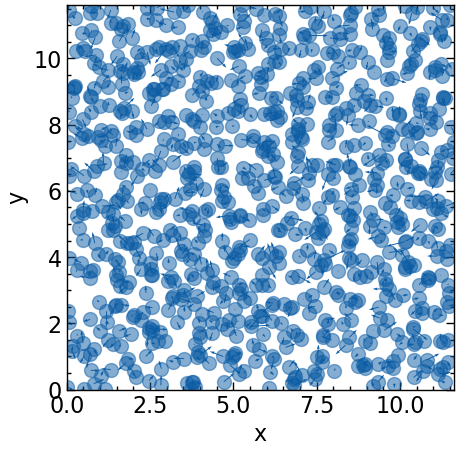

In [8]:
plt.figure(figsize=(5,5))
plt.plot(lj.x,lj.y,'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(lj.x,lj.y,lj.vx,lj.vy,color='C0') # vetor de velocidade

plt.xlim(0,lj.Lx)
plt.ylim(0,lj.Ly)

plt.xlabel('x')
plt.ylabel('y')

Distribuição das partículas

(0.0, 0.2)

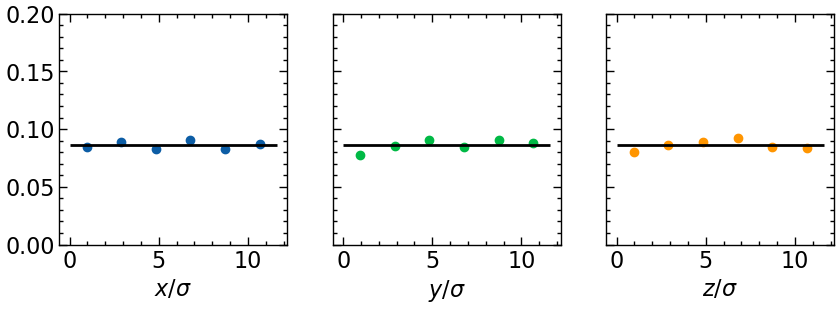

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(10,3))

n, bins = np.histogram(lj.x,bins=6,range=(0,lj.Lx),density=True) # é uma outra forma de fazer histograma
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[0].scatter(meanbins,n,marker='o',color='C0')
axs[0].hlines(y=rho*lj.Lx*lj.Ly/lj.N_atoms,xmin=0,xmax=lj.Lx,color='k')
axs[0].set_xlabel(r'$x/\sigma$')

n, bins = np.histogram(lj.y,bins=6,range=(0,lj.Ly),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[1].scatter(meanbins,n,marker='o',color='C1')
axs[1].hlines(y=rho*lj.Lx*lj.Lz/lj.N_atoms,xmin=0,xmax=lj.Ly,color='k')
axs[1].set_xlabel(r'$y/\sigma$')

n, bins = np.histogram(lj.z,bins=6,range=(0,lj.Lz),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[2].scatter(meanbins,n,marker='o',color='C2')
axs[2].hlines(y=rho*lj.Ly*lj.Lz/lj.N_atoms,xmin=0,xmax=lj.Lz,color='k')
axs[2].set_xlabel(r'$z/\sigma$')

axs[0].set_ylim(0,0.2)

Distribuição de Velocidades

(0.0, 0.5)

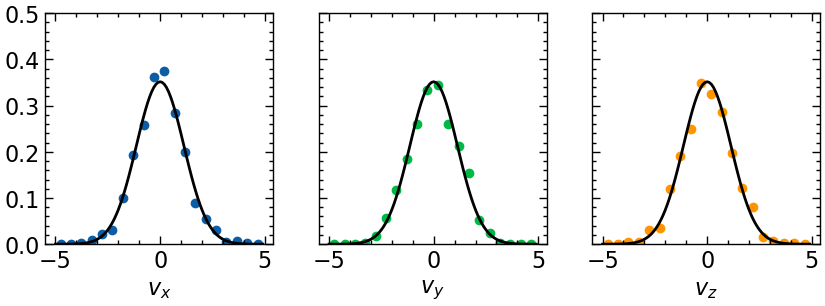

In [10]:
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(10,3))

vx = np.arange(-5,5,0.1)
fvx = np.exp(-vx**2/(2*T[-1]))/np.sqrt(2*np.pi*T[-1])

n, bins = np.histogram(lj.vx,bins=20,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[0].scatter(meanbins,n,marker='o',color='C0')
axs[0].plot(vx,fvx,'k')
axs[0].set_xlabel(r'$v_x$')

n, bins = np.histogram(lj.vy,bins=20,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[1].scatter(meanbins,n,marker='o',color='C1')
axs[1].plot(vx,fvx,'k')
axs[1].set_xlabel(r'$v_y$')

n, bins = np.histogram(lj.vz,bins=20,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[2].scatter(meanbins,n,marker='o',color='C2')
axs[2].plot(vx,fvx,'k')
axs[2].set_xlabel(r'$v_z$')

axs[0].set_ylim(0,0.5)

Gráfico da evolução de $U$ e $T$ como função dos passos de iteração

Text(0, 0.5, '$P \\sigma^3/\\epsilon$')

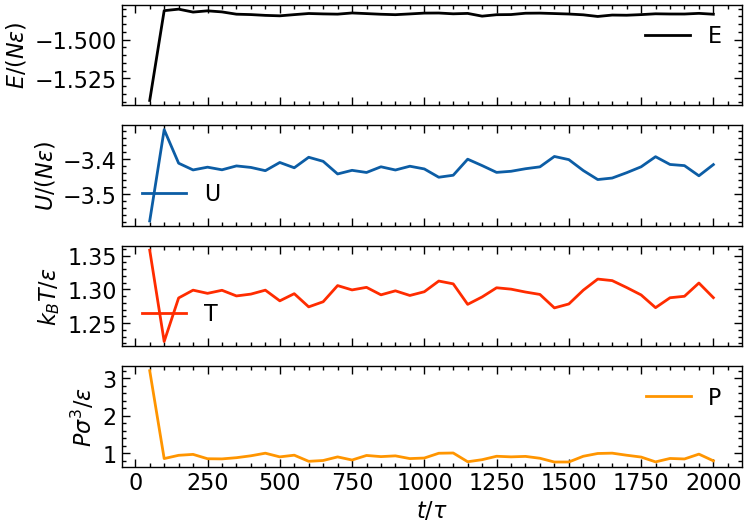

In [11]:
fig, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(t,E/lj.N_atoms,'k',label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel(r'$E/(N\epsilon)$')

axs[1].plot(t,U/lj.N_atoms,label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel(r'$U/(N\epsilon)$')

axs[2].plot(t,T,color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_ylabel(r'$k_B T/\epsilon$')

axs[3].plot(t,P,color='C2',label='P')
axs[3].legend(loc='best')
axs[3].set_xlabel(r'$t/\tau$')
axs[3].set_ylabel(r'$P \sigma^3/\epsilon$')

## Calculando Médias e Desvios Padrão

In [12]:
teq = 300
subsett = t[t>teq]
subsetT = T[t>teq]
subsetP = P[t>teq]
subsetU = U[t>teq]/lj.N_atoms

Energia Interna

In [13]:
Umean = subsetU.mean()

print(Umean)

-3.4247580726422493


In [14]:
sigmaU = subsetU.std()

print(sigmaU)

0.01705338750422086


$$u^* = U/N\epsilon = -3.43 \pm 0.02 $$

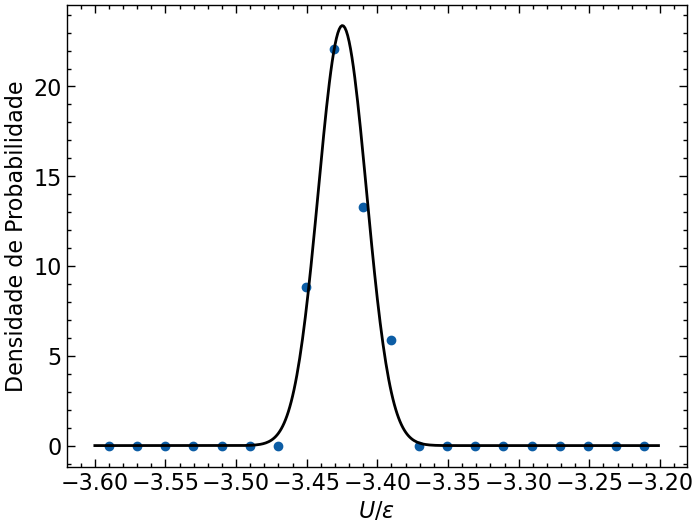

In [26]:
# plt.hist(subsetU,bins=6,density=True)
plt.xlabel(r'$U/\epsilon$')
plt.ylabel('Densidade de Probabilidade')

uarray = np.arange(-3.6,-3.2,0.001)
plt.plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

n, bins = np.histogram(subsetU,bins=20,range=(uarray.min(),uarray.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
plt.scatter(meanbins,n,marker='o',color='C0')

Temperatura

In [16]:
Tmean = subsetT.mean()

print(Tmean)

1.294072210582625


In [17]:
sigmaT = subsetT.std()

print(sigmaT)

0.01129237316438771


$$ T^* = k_B T /\epsilon = 1.29 \pm 0.01$$

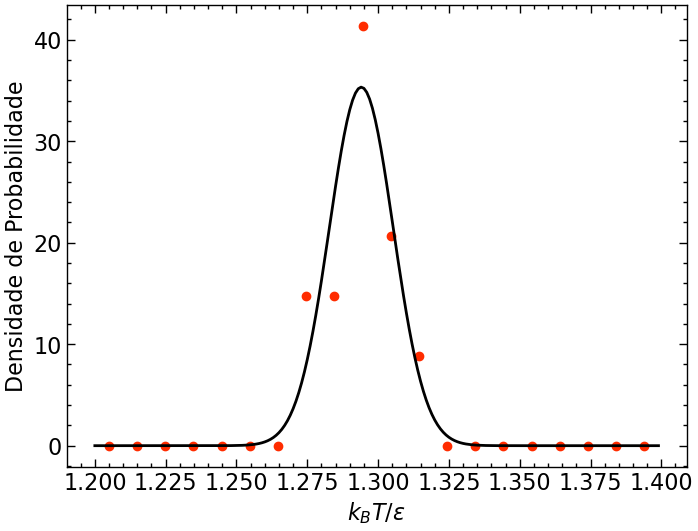

In [25]:
# plt.hist(subsetT,bins=6,density=True,color='C3')
plt.xlabel(r'$k_B T/\epsilon$')
plt.ylabel('Densidade de Probabilidade')

Tarray = np.arange(1.2,1.4,0.001)
plt.plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

n, bins = np.histogram(subsetT,bins=20,range=(Tarray.min(),Tarray.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
plt.scatter(meanbins,n,marker='o',color='C3')

Pressão

In [19]:
Pmean = subsetP.mean()

print(Pmean)

0.8923056378384587


In [20]:
sigmaP = subsetP.std()

print(sigmaP)

0.07352322893945508


$$P^* = P \sigma^3 /\epsilon = 0.89 \pm 0.07 $$

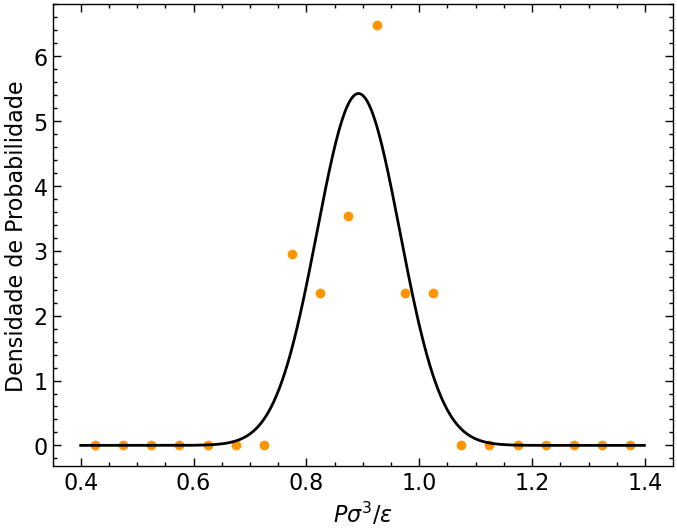

In [24]:
# plt.hist(subsetP,bins=6,density=True,color='C2')
plt.xlabel(r'$P \sigma^3/\epsilon$')
plt.ylabel('Densidade de Probabilidade')

Parray = np.arange(0.4,1.4,0.001)
plt.plot(Parray,np.sqrt(1/(2*np.pi*sigmaP**2))*np.exp(-0.5*(Parray-Pmean)**2/sigmaP**2),color='k')

n, bins = np.histogram(subsetP,bins=20,range=(Parray.min(),Parray.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
plt.scatter(meanbins,n,marker='o',color='C2')